# __Epidemiological Analysis Visualisations__
         Looking into distribution patterns within a population system: 
      Who, Where and When & linking data to food source attribution What
***

In [1]:
#imported libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

import geopandas as gpd
import plotly.express as px
import fiona
import matplotlib.colors as colors

In [2]:
#imported file with patient metadata and isolate information
human = pd.read_excel("/directory/file.xlsx", index_col=[0])

# 0. Pre - Analysis

## Cleaning data, deduplicating datasets 

* Remove repeated isolates
* Mother-infant pairs treated as a single data entry
* Remove quality isoaltes

In [3]:
human = human.drop(human.loc[human["IsolatesID"]=="IQA"].index)

For Mother-Infant pairs:
Use t5 SNP difference distance to identify isolates with the same digit code profile

In [4]:
human["SNP Level 5"].value_counts().head(10)

 1.1.11.11.11.11         5
 1.53.182.274.285.297    4
 1.1.20.20.346.363       2
 1.1.10.13.103.104       1
 1.1.5.296.312.328       1
 1.1.322.358.389.410     1
 1.1.324.361.393.415     1
 1.1.328.365.399.432     1
 1.1.329.366.400.433     1
 1.1.4.294.310.326       1
Name: SNP Level 5, dtype: int64

In [5]:
#remove isolates with drop
human.loc[human["snp"].str.contains("...snpaddress...")]
human = human.drop("IsolatesID")

# 1. Who

## Calculate age from patients date of birth and sample collection date

In [6]:
#"Receipt Date" is the sequence collection date
#Alter type of "Receipt Date" and patients "Date of Birth" data into numrical dates with datetime.
human["Receipt Date"] = pd.to_datetime(human["Receipt Date"], format="%Y-%m-%d")
human["Date of birth"] = pd.to_datetime(human["Date of birth"], format="%Y-%m-%d")

#format diplay of dates into Years and Months only
human["Receipt M-Y"] = pd.to_datetime(human["Receipt Date"], 
                                      format="%Y-%m").dt.to_period("m")
#calculate patient's age
human["Age"] = ((human["Receipt Date"] - human["Date of birth"])/ 
                timedelta(days=365)).round(0)

## Create horizontal pyramid bar plot to visualise patient distribution across age groups

In [7]:
# subselect Age and Sex data from original human dataset
pop = human[["Age", "Sex"]]

#### Create table with sex, age groups and number of cases

In [8]:
#create number of bins for each bracket
bins=[-1,1,6,10,19,29,39,49,58,68,78,88,105]

#label each bin with age bracket
labels = ['0',"1-5",'6-10','11-19','20-29','30-39','40-49','50-59','60-69','70-79', "80-89", "90+"]

#create column named "Age Groups", which contains the labels of the bins generated
a_g = pd.cut(pop["Age"], bins, labels=labels)
pop.insert(2, "Age Groups", a_g)

#group data according to sex
a = pop.groupby("Sex")

#calculate the occurences of each age group bin
a = a["Age Groups"].value_counts().sort_index().to_frame().reset_index()

#rename columns
a.columns= ["Sex", "Age Groups", "Num Isolates"]
a

,Sex,Age Groups,Num Isolates
0,F,0,3
1,F,1-5,0
2,F,6-10,0
3,F,11-19,1
4,F,20-29,3
5,F,30-39,8
6,F,40-49,1
7,F,50-59,1
8,F,60-69,3
9,F,70-79,3


In [9]:
#restructure orientation of df for graph
a = a.pivot(index='Age Groups', columns="Sex", values="Num Isolates")
a

Sex,F,M
Age Groups,,
0,3,4
1-5,0,0
6-10,0,0
11-19,1,0
20-29,3,2
30-39,8,2
40-49,1,3
50-59,1,2
60-69,3,4


#### Plot horizontal pyramid bar plot

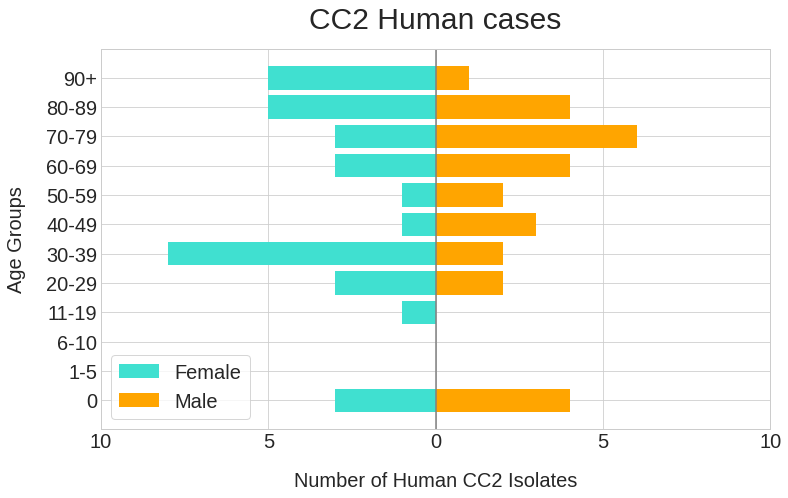

In [10]:
#library for seaborn pallet use 
plt.style.use("seaborn-whitegrid")

#define size of figure
plt.figure(figsize=(12,7))

#matrix with number of cases
no_cases = a.values

#setting y value as the label name of each age bracket
y = a.index

#setting x1 and x2 values as the male and female number of cases per age bracket
x_f= a["F"]*(-1)
x_m= a["M"] 

#matplotlib horizontal bar plot - plotting male and female cases sepatetly
plt.barh(y, x_f, align='center', color='turquoise', label="Female")
plt.barh(y, x_m, align='center', color='orange', label="Male")

#setting x-axis markers and labels
xtickval = [-10, -5, 0, 5, 10]
xticknames = ["10", "5", "0", "5", "10"]
plt.xticks(xtickval, xticknames, fontsize=20)

#setting font for y-axis marker labels
plt.yticks(fontsize=20)

#setting labels for x and y-axis
plt.xlabel("Number of Human CC2 Isolates", fontsize=20, labelpad=20)
plt.ylabel("Age Groups", fontsize=20, labelpad=20)

#setting parameters for legend displayed within the graph
plt.legend(loc="lower left", frameon=True, fontsize=20)

#setting header for figure
plt.title("CC2 Human cases", fontsize=30, pad=20)

#inserting grid on graph
plt.grid(True)

#adjusting the x-axis separating female to male bars
plt.axvline(x=0, linestyle="-",color="gray")

#display figure
plt.show()

# 2. What - Clinical severity

#### Adding clinical outcome (recorded deaths) to patient distribution pyramid plot

In [11]:
#subselect age, sex and clinical outcome ("Death") from origincal dataset
ages_death = human[["Age", "Sex","Death"]]

same process followed as previous section, however the dataset are now grouped by Death and Sex

In [12]:
#see code above
s_d_a_iso = ages_death.groupby(["Death", "Sex"])

In [13]:
#reset orientation of df 
s_d_a_iso = s_d_a_iso.pivot(index='Age Groups', columns=["Sex", "Death"], 
                            values="Num Isolates")
s_d_a_iso

Sex         F  M  F     M  F  M
Death       N  N PD  U  U  Y  Y
Age Groups                     
0           1  3  1  1  1  0  0
1-5         0  0  0  0  0  0  0
6-10        0  0  0  0  0  0  0
11-19       1  0  0  0  0  0  0
20-29       1  2  2  0  0  0  0
30-39       6  1  2  0  0  0  1
40-49       0  2  1  0  1  0  0
50-59       1  2  0  0  0  0  0
60-69       1  2  0  0  0  2  2
70-79       2  4  0  0  0  1  2
80-89       3  2  0  1  0  1  2
90+         3  0  0  0  0  2  1

#### Pyramid plot with clinical outcome

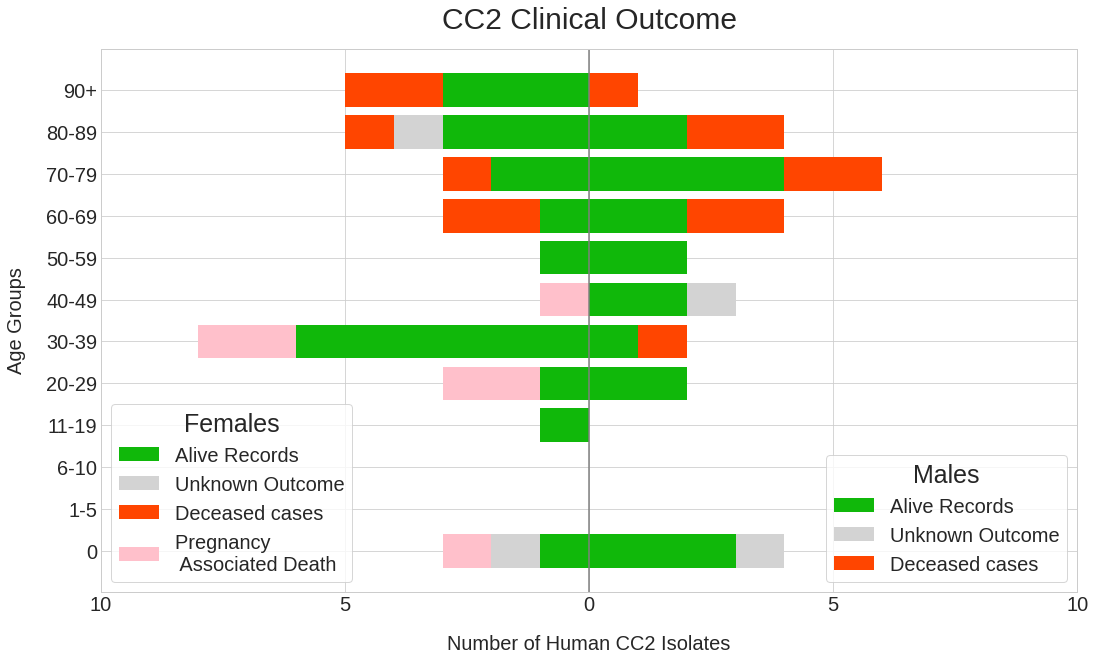

In [14]:
#library for plot pallet with seaborn
plt.style.use("seaborn-whitegrid")

#setting figure size
fig, ax = plt.subplots(figsize=(17.5,10))

#setting parameters for figure and subplots
plt.rcParams["hatch.color"]="floralwhite"
plt.rcParams["hatch.linewidth"]= 4
plt.rcParams["legend.title_fontsize"]=25

#setting x and y variables for plot
y = s_d_a_iso.index

x_f1= s_d_a_iso["F"]["N"]*(-1)
x_f2= s_d_a_iso["F"]["U"]*(-1)
x_f3= s_d_a_iso["F"]["Y"]*(-1)
x_f4= s_d_a_iso["F"]["PD"]*(-1)

x_m1 = s_d_a_iso["M"]["N"]
x_m2 = s_d_a_iso["M"]["U"]
x_m3 = s_d_a_iso["M"]["Y"]

#horizontal bar plot for females
plt.barh(y,x_f1, align='center', color= "#10b80a", label="Alive cases")
plt.barh(y,x_f2, left=x_f1, align='center', color='lightgray', label="Unknown Outcome")
plt.barh(y,x_f3, left=x_f1+x_f2, align='center', color='orangered', label="Deceased cases")
plt.barh(y,x_f4, left=x_f1+x_f2+x_f3, align='center', color='pink', label="Pregnancy Associated Death")

#horizontal bar plot for males
b1 = plt.barh(y,x_m1, align='center', color='#10b80a', label="Alive Records")
b2 = plt.barh(y,x_m2, left=x_m1, align='center', color='lightgray', label="Unknown Outcome")
b3 = plt.barh(y,x_m3, left=x_m1+x_m2, align='center', color='orangered', label="Deceased cases")

#setting x and y-axis as in previous plot
xtickval = [-10, -5, 0, 5, 10]
xticknames = ["10", "5", "0", "5", "10"]
plt.xticks(xtickval, xticknames, fontsize=20)
plt.yticks(fontsize=20)

#axis labels
plt.xlabel("Number of Human CC2 Isolates", fontsize=20, labelpad=20)
plt.ylabel("Age Groups", fontsize=20, labelpad=20)

#setting two legends for each sex
#legend for females
leg = plt.legend(b1, labels=["Alive Records","Unknown Outcome", "Deceased cases", 
                         "Pregnancy \n Associated Death"],
                 loc="lower left", frameon=True, fontsize=20, title="Females")
#adding additional legend
ax.add_artist(leg)
#legend for males
plt.legend(labels=["Alive Records","Unknown Outcome", "Deceased cases"],
           loc="lower right", frameon=True, fontsize=20, title="Males")

#Tittle for figure
plt.title("CC2 Clinical Outcome", fontsize=30, pad=20)

#adjusting the x-axis separating female to male bars
plt.axvline(x=0, linestyle="-",color="gray")

#display plot
plt.show()

# 3. When - Time

## Time series for clinical isolates

detect temporal signal in outbreaks and visualise peaks in cases

creating df with number of cases per set period

In [15]:
#setting data dates into corrent numerical format 
human["Receipt Date"] = pd.to_datetime(human["Receipt Date"], format="%Y-%m-%d")
human["Receipt M-Y"] = pd.to_datetime(human["Receipt Date"], format="%Y-%m").dt.to_period("m")

In [16]:
#count number of cases per month
time_hum = human["Receipt M-Y"].loc[human["Specimen Source"]=="Human"].value_counts().sort_index().to_frame().reset_index()
#reset column headers
time_hum.columns=["Receipt M-Y", "No Isolates"]
time_hum.head()

,Receipt M-Y,No Isolates
0,2015-01,1
1,2015-03,1
2,2015-05,2
3,2015-06,2
4,2015-07,2


#### Time series plot

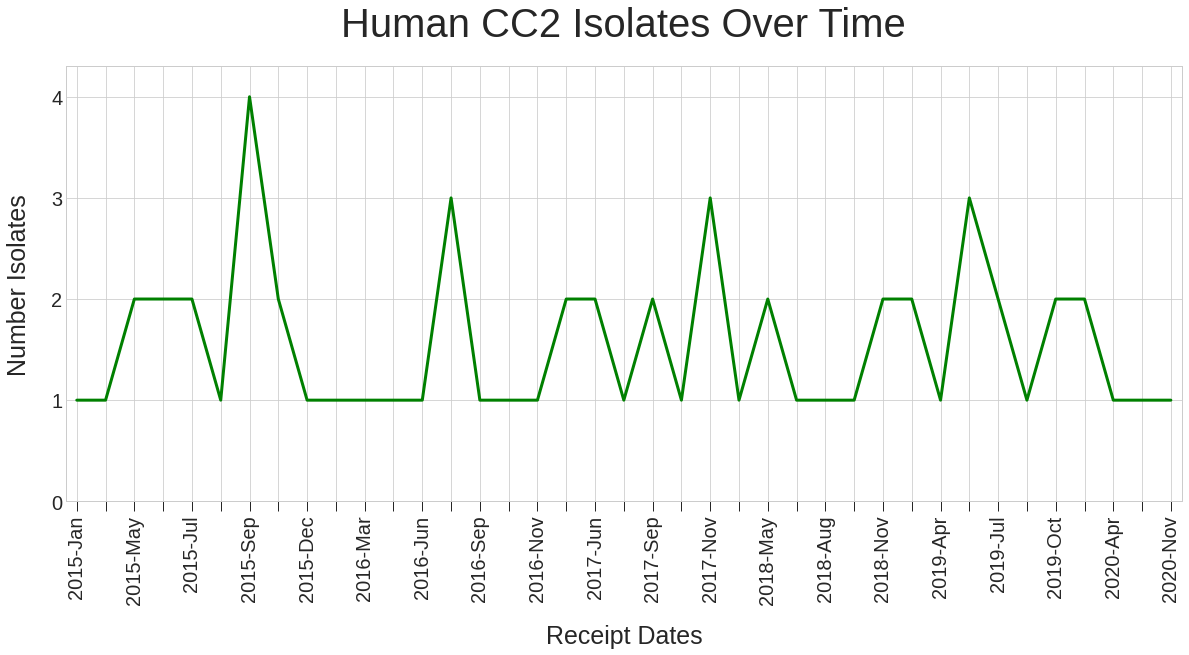

In [17]:
#import seaborn library for plot visualisation
import seaborn as sns

#set figure parameters  
plt.style.use("seaborn-whitegrid")
plt.rcParams["xtick.major.size"]= 10
plt.rcParams["xtick.major.width"]= 1
fig = plt.figure(figsize=(20,8))
#adjust white space in axis
plt.margins(0.01,0.1)

#setting dates in the right numberical format for x-axis
x_dates = time_hum["Receipt M-Y"].dt.strftime("%Y-%b")
x_range = np.arange(len(x_dates))

#plot
plot = sns.lineplot(x_range, time_hum["No Isolates"], color="green", linewidth=3)#, label="Snapper")

#axis labels
plt.xlabel("Receipt Dates", fontsize=25, labelpad=20)
plt.ylabel("Number Isolates", fontsize=25, labelpad=20)

#set x and y-axis markers and labels
plt.xticks(x_range, x_dates, fontsize=20, rotation=90)
plt.yticks(np.arange(0,5), fontsize=20)

#skip every other tick marker point on axis
for ind, label in enumerate(plot.get_xticklabels()):
    if ind % 2 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

#set Tittle for figure
plt.title("Human CC2 Isolates Over Time", fontsize=40, pad=30)

#display figure
plt.show()

# 4. Where - Place

## Display clinical cases on map

#### detect temporal signal on cases and see geographic distribution
to plot a map with geopandas a shape file (.shp) is required. 
for analysis all files containing geographic information where downloaded from the ONS site


https://geoportal.statistics.gov.uk/search?q=BDY_ADM&sort=Date%20Created%7Ccreated%7Cdesc

In [18]:
#import shape file and files with postcode information
shape = gpd.read_file("/directory/shape_file.shp")
national_postcodes = pd.read_csv("postcodes.csv")
national_postcodes = national_postcodes[["Postcode 3", "Longitude", "Latitude"]]
national_postcodes.rename(columns = {'Postcode 3':'Postcode'}, inplace = True)

In [19]:
#add postcode information on human dataset
human_lon_lat = pd.merge(human, national_postcodes, on="Postcode", how="left")

In [20]:
#convert dataset to correct format with geopandas for map plot
hum_geo = gpd.GeoDataFrame(human_lon_lat, 
                           geometry = gpd.points_from_xy(human_lon_lat["Longitude"], 
                                                         human_lon_lat["Latitude"]))

In [21]:
#add UK population size so generate heatmap of population density
popsize = pd.read_excel("/directory/uk_population.xls", 
                        sheet_name = "MYE2 - Persons", skiprows=range(1,7), header=1)
popsize.rename(columns = {'Name':'LAD21NM'}, inplace = True)
popsize = popsize[["LAD21NM", "All ages"]]
popsize.head()

,LAD21NM,All ages
0,UNITED KINGDOM,67081234
1,GREAT BRITAIN,65185724
2,ENGLAND AND WALES,59719724
3,ENGLAND,56550138
4,NORTH EAST,2680763


In [22]:
#add population size on shape file
shape = pd.merge(shape, popsize, on="LAD21NM", how="left")
shape.loc[~shape["All ages"].astype(str).str.contains(r"[0-9]",regex=True, na=True), ["All ages"]]=403687.0

In [23]:
#edit projections for geopandas to register geographic coordinates for longitude and latitude
#requires fiona library
shape = shape.to_crs(epsg=4326)
df_geo = hum_geo.set_crs(epsg=4326, inplace=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


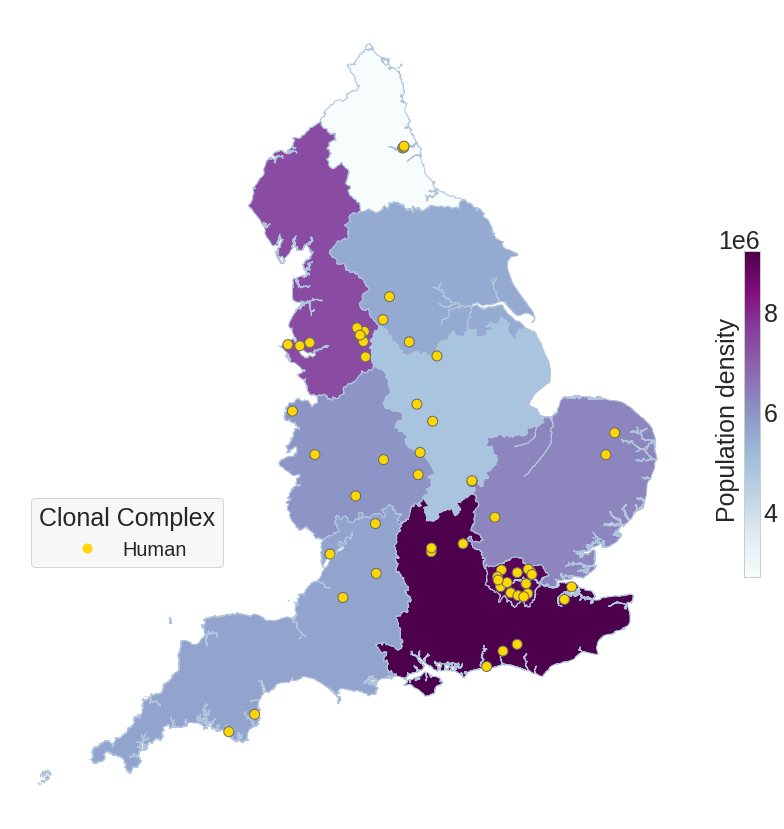

In [24]:
# plotting parameters
fig, ax = plt.subplots(figsize=(20, 15))
plt.rcParams["font.size"] = 25

#set colour for clinical points on map
color_dict = {"Human": "gold"}

#first plot of the UK map representing the population density as a heat map
ax1 = shape2.plot(ax=ax, column="All ages", edgecolor="lightsteelblue", cmap="BuPu", legend=True,
            legend_kwds={"orientation": "vertical", "pad": 0.05, "shrink": 0.4})

# adjust the position of the main legend
legend1 = ax.legend(title="Population density", bbox_to_anchor=(0.8, 0.5,0.31,0.14), ncol=len(ax.lines))
fig.gca().add_artist(legend1)

#projecting clinical cases on the UK map
ax2 = testdf.plot(ax=ax,
            column='Specimen Source',
            legend=True,
            edgecolors="dimgray",
            markersize=100,
            legend_kwds={"title":"Clonal Complex","loc":"lower left",
                         "frameon": True, "facecolor":"whitesmoke", 
                         "bbox_to_anchor":(0.02,0.30,0,0), "fontsize":20},
           cmap=colors.ListedColormap(list(color_dict.values())))

# rotate the title of the main legend
legend1.get_title().set_rotation("vertical")
legend1.get_title().set_verticalalignment("bottom")

# hide axis of figure
plt.axis("off")
# #display figure
plt.show()

# 5. Why/ How - Transmission

## Visualising food groups most commonly sampled from food samples 

## Pre - Analysis

In [25]:
#import food data
env_food = pd.read_excel("/directory/food_samples.xlsx", index_col=[0])
#remove duplocated isolates
env_food = env_food.drop(env_food.loc[env_food["Duplicates?"]=="D"].index)

In [26]:
#edit dates into numerical date format with datatime
env_food["Receipt Date"] = pd.to_datetime(env_food["Receipt Date"], format="%Y-%m-%d")

env_food["Receipt M-Y"] = pd.to_datetime(env_food["Receipt Date"]
                                         , format="%Y-%m").dt.to_period("m")

#### Group foods into food categories

In [27]:
food = env_food.loc[env_food["Specimen Source"]=="Food"]

food.loc[~(food["Food Category"].str.contains("^[A-Z]", case=False, na=False)) & 
         (food["Surname"].str.contains("Salmon|cod|trout|...'fresh fish'", 
                                       case=False)), "Food Category"]="Fish"

food.loc[~(food["Food Category"].str.contains("^[A-Z]", case=False, na=False)) & 
         (food["Surname"].str.contains("Pizza|cooked rice|...'ready-made, package foods'", 
                                       case=False)), "Food Category"]="Chill and Cook Meals"

food.loc[~(food["Food Category"].str.contains("^[A-Z]", case=False, na=False)) & 
         (food["Surname"].str.contains("chorizo|salami|sliced|...'cured and processed meat products'", 
                                       case=False)), "Food Category"]="Deli/Charcuterie foods \n (incl. cooked and cured meats)"

food.loc[~(food["Food Category"].str.contains("^[A-Z]", case=False, na=False)) & 
         (food["Surname"].str.contains("salad|sandw|...'RTE produce'", 
                                       case=False)), "Food Category"]="Other RTE \n (incl. sandwiches, mixed salads)"

food.loc[~(food["Food Category"].str.contains("^[A-Z]", case=False, na=False)) & 
         (food["Surname"].str.contains("ice cream|milk|cheese|...'dairy_produce'", 
                                       case=False)), "Food Category"]="Dairy \n (incl. pasteurised/raw)"

food.loc[~(food["Food Category"].str.contains("^[A-Z]", case=False, na=False)) & 
         (food["Surname"].str.contains("lettuce|sweetcorn|melon...'frozen and fresh fruit and veg'", 
                                       case=False)), "Food Category"]="Veg & Fruit \n (fresh&frozen)"

#### Pie chart plot of all food groups

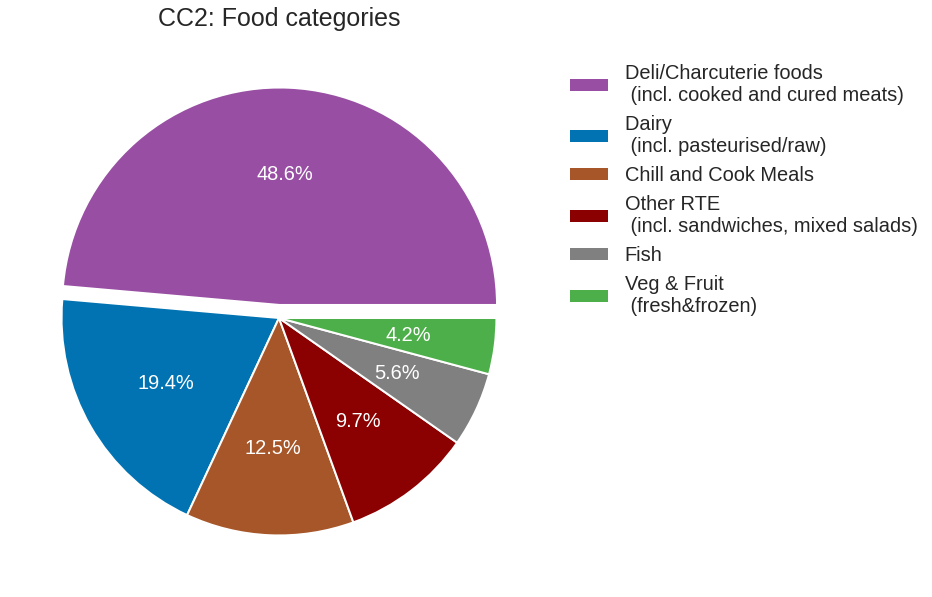

In [28]:
#generate table with food categories and colours 
c = {"Dairy \n (incl. pasteurised/raw)":"#0173b2", 
     "Fish":"gray", 
     "Veg & Fruit \n (fresh&frozen)":"#4daf4a", 
     "Other RTE \n (incl. sandwiches, mixed salads)":"darkred", 
     "Chill and Cook Meals":"#a65628", 
     "Deli/Charcuterie foods \n (incl. cooked and cured meats)":"#984ea3", 
     "Raw meat":"#f781bf"}
t = cc2["Food_Category_V2"].value_counts().to_frame()

t["colours"]=t.index.to_series().map(c)
t = t.T

#set figure size
plt.figure(figsize=(10,10))

#set variables for plot
v = t.loc["Food_Category_V2"].values

#pie chart plot
plots, text, precent = plt.pie(v, colors= t.loc["colours"].values, 
                              autopct="%1.1f%%", textprops={"fontsize":20}, startangle=0,
       explode=[0.06,0,0,0,0,0],
       wedgeprops={"linewidth":2.0, "edgecolor":"white"})

#set precentage parameters
plt.setp(precent,color="w", fontweight="medium")

#set figure legend
plt.legend(labels=t.columns, loc="upper left", fontsize=20, bbox_to_anchor=(1,1))

#set Tittle for figure
plt.title("CC2: Food categories", fontdict={"fontsize":25}, pad=20)

#display figure
plt.show()

Deduplicate dataset:
keep a sigle entry for isolates with:
* the same t5 SNP dirrerence
* the same sequence collection date
* collected at the same location

In [29]:
food_dedup = food.drop_duplicates(subset=["Surname","Receipt M-Y", "SNP Level 5"],keep="first")

#### Repeat same steps to generate pie chart plot for deduplicated dataset

this analysis allows for the investigation and comparison of both raw sample collection and the representative population structure

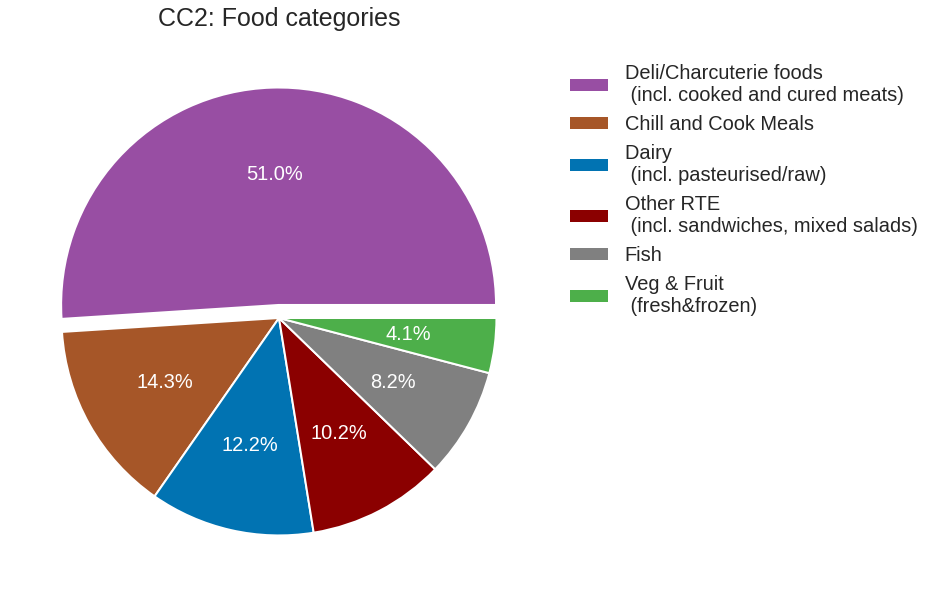

In [30]:
#see code above
#Normalised dataset